In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Dataset

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [3]:
batch_size = 32

In [4]:
class Data(Dataset):
    def __init__(self):
        self.x = np.linspace(-10,10, 1000)
        self.y = np.array([np.sin(i)/i - i/10 for i in self.x])
        self.num = batch_size

    def __getitem__(self, idx):
        # return torch.FloatTensor([point, self.func(point)])
        return torch.FloatTensor([self.x[idx], self.y[idx]])

    def __len__(self):
        return self.num

In [5]:
data = Data()

In [6]:
data[0]

tensor([-10.0000,   0.9456])

In [7]:

data_loader = DataLoader(data, batch_size = batch_size, shuffle=True)

In [8]:
class Generator(nn.Module):
    def __init__(self, laten_dim, hidden_dim):
        super().__init__()
        self.tanh = nn.Tanh()
        self.linear1 = nn.Linear(laten_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 2)


    def forward(self, x):
      out = self.linear1(x)
      out = self.tanh(out)
      out = self.linear2(out)
      # out = self.tanh(out)

      return out


In [9]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        self.linear1 = nn.Linear(2, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear3 = nn.Linear(hidden_dim//2, 1)
        self.lrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.lrelu(out)
        out = self.linear2(out)
        out = self.lrelu(out)
        out = self.linear3(out)
        out = self.sigmoid(out)

        return out

In [10]:
n_epochs = 200 # количество эпох
lr = 0.01 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 1 # Размерность случайного вектора, который подается на вход генератору
hidden_dim = 64

In [11]:
generator = Generator(latent_dim, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss().to(device)

In [12]:
d_loss_history = []
g_loss_history = []

In [13]:
# for i, x in enumerate(data_loader):
#   valid = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
#   print(valid)
#   break

Epoch: 50; Discriminator_loss: 0.826; Generator_loss: 0.992


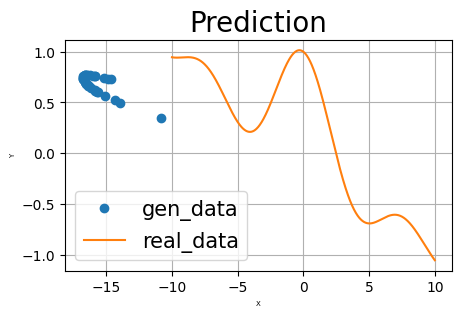

Epoch: 100; Discriminator_loss: 0.768; Generator_loss: 0.572


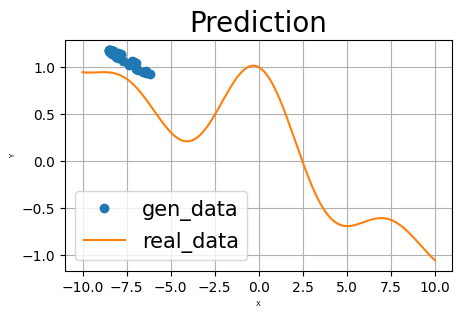

Epoch: 150; Discriminator_loss: 0.672; Generator_loss: 0.75


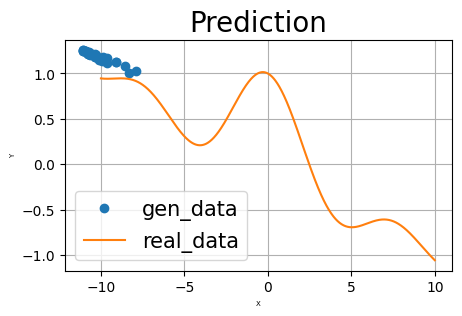

Epoch: 200; Discriminator_loss: 0.703; Generator_loss: 0.764


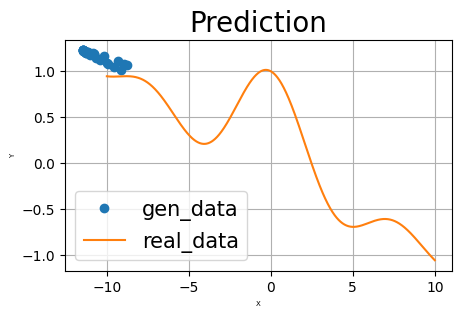

In [14]:
from pickle import READONLY_BUFFER
for epoch in range(n_epochs):
  d_loss_mean = 0.0
  g_loss_mean = 0.0
  for i, data in enumerate(data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device)

        # real_data = data.type(torch.FloatTensor).to(device)
        real_data = data.type(torch.Tensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)

######################  Тренировка дискриминатора    ##########################

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_data)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_data)

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################

        # генерация шума
        # z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_data)

        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)

        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        d_loss_mean += d_loss.item()
        g_loss_mean += g_loss.item()

######## Отображение процесса обучения и вывод функций потерь ############
        if (epoch + 1) % 50 == 0:
          print(f'Epoch: {epoch + 1}; '\
                  f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
                  f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')

          plt.figure(figsize = (5,3))
          plt.title('Prediction', fontsize = 20)
          plt.grid(True)
          plt.ylabel('Y', fontsize = 5)
          plt.xlabel('X', fontsize = 5)

          gen_data = gen_data.cpu().detach().numpy()
          plt.plot(gen_data[:,0], gen_data[:,1], 'o', label='gen_data')
          x = np.linspace(-10,10, 1000)
          y = np.array([np.sin(i)/i - i/10 for i in x])
          plt.plot(x, y, label='real_data')

          plt.legend(fontsize = 15)
          plt.show()

        d_loss_history.append(d_loss_mean / len(data_loader))
        g_loss_history.append(g_loss_mean / len(data_loader))
